In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm.basic import LightGBMError

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Stacking Ensemble

- 스태킹은 1차 모델 2차 모델이 필요하다
- 1차모델은 앙상블을 진행할 여러 모델
- 2차모델은 1차 모델의 예측결과를 인풋으로 받아 아웃풋을 내는 모델


장점 

- 캐글에서 좋은 점수를 받기 위해 자주 사용된다고 함

단점 

- 과적합의 우려가 높다

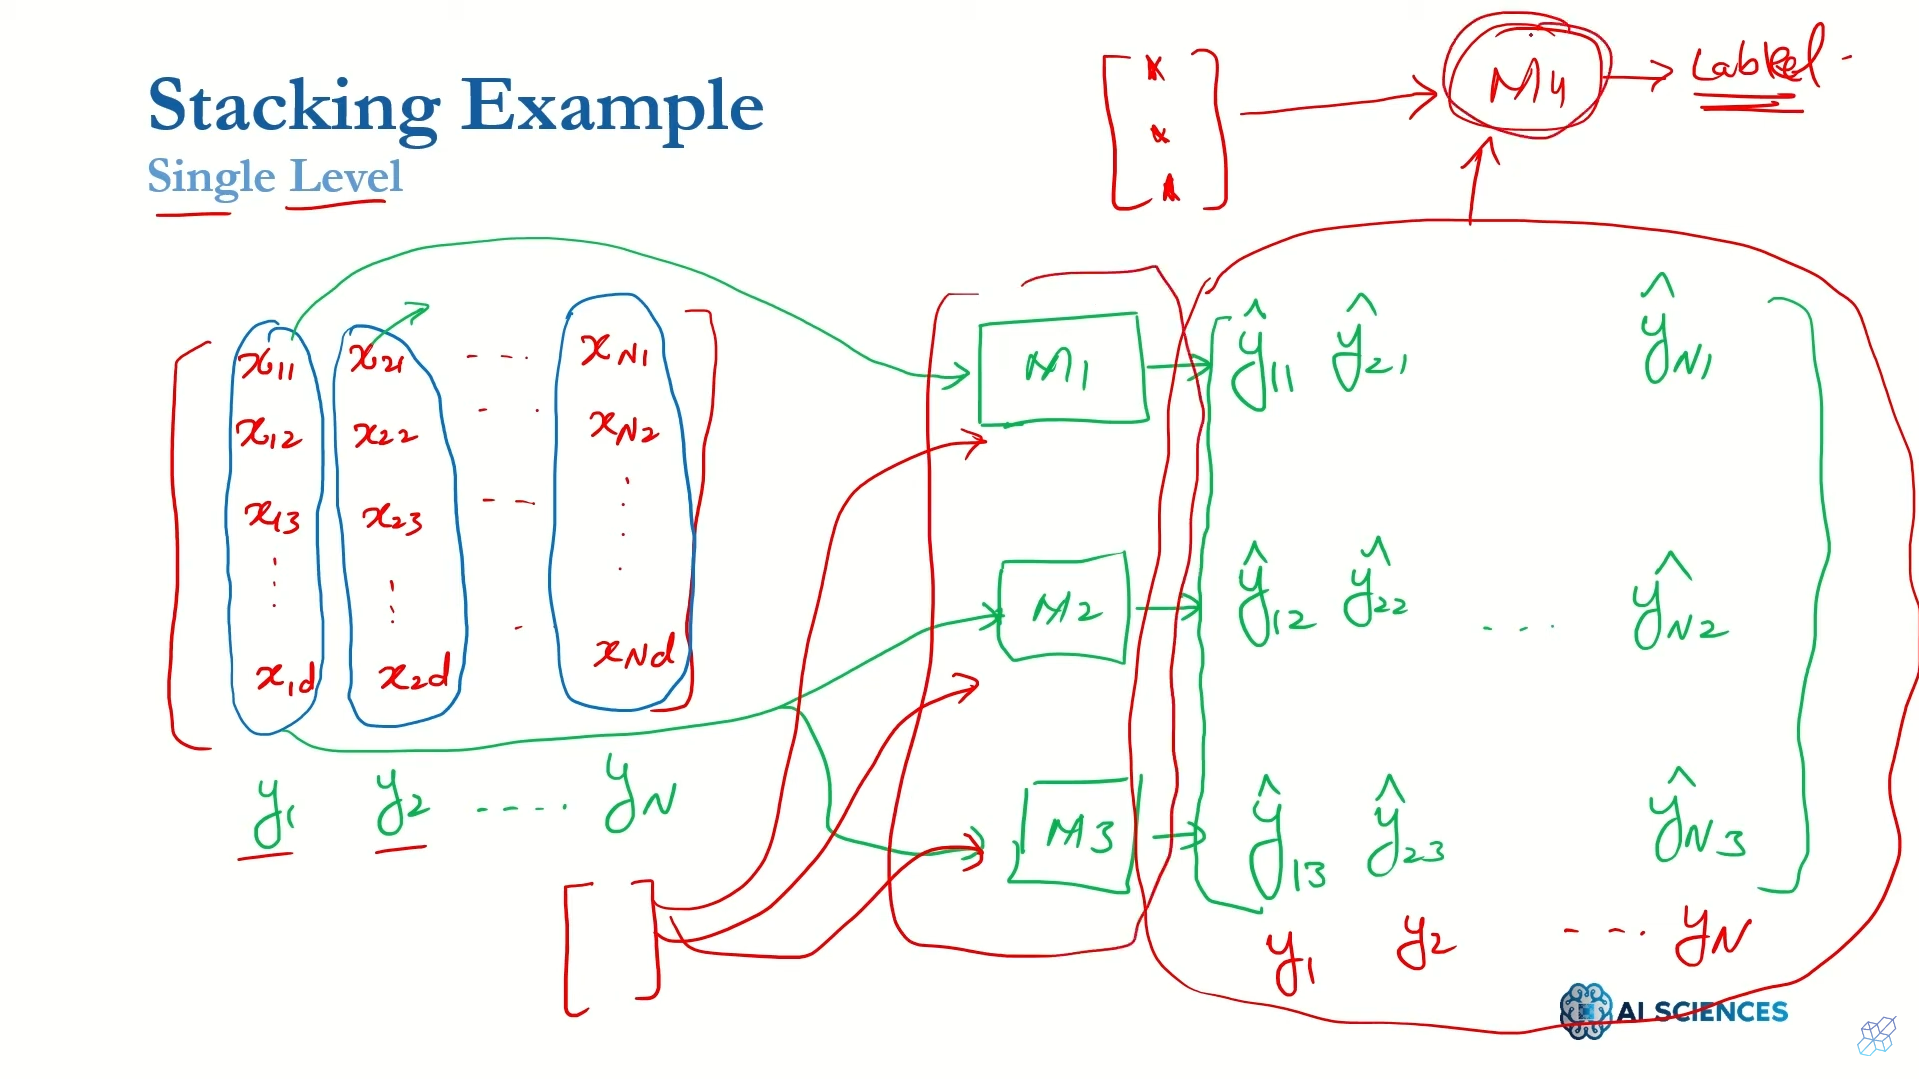

In [2]:
# Load the dataset
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")

In [3]:
# Basic data information
print("Train:", len(df_train))
print("Test:", len(df_test))
print(df_train.head())
print(df_test.head())

Train: 1117957
Test: 745305
   id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  Dr

### Feature Engineering 

- 컬럼들의 스케일링 값

In [4]:
# Separate target variable before feature engineering
y = df_train['FloodProbability']
X_train = df_train.drop(columns=['id', 'FloodProbability'])
X_test = df_test.drop(columns=['id'])

In [5]:
# Feature Engineering Function
def feature_engineering(df):
    # Interaction features
    df['feature_sum'] = df.sum(axis=1)
    df['feature_mean'] = df.mean(axis=1)
    df['feature_std'] = df.std(axis=1)
    df['feature_min'] = df.min(axis=1)
    df['feature_max'] = df.max(axis=1)

    # Polynomial features
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(df)
    poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(df.columns))
    df = pd.concat([df, poly_df], axis=1)

    return df

In [6]:
# Apply feature engineering
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [7]:
# Ensure no duplicate feature names
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# 🚀 Stacking Ensemble
**The stacking ensemble combines LightGBM, XGBoost, and CatBoost to leverage the strengths of each model and improve prediction accuracy.**

In [25]:
df2.mean?

In [23]:
dir(df2)

['A',
 'B',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '

In [8]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [9]:
# Model definitions
lgb_model = lgb.LGBMRegressor()
xgb_model = XGBRegressor()
cat_model = CatBoostRegressor(verbose=0)

In [10]:
# Stacking Regressor
estimators = [
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('cat', cat_model)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=lgb.LGBMRegressor()
)

In [11]:
# # Train and validate the stacking model
# try:
#     stacking_model.fit(X_train, y_train)
# except LightGBMError as e:
#     print(f"LightGBMError: {e}")
#     # Identify and resolve duplicate features
#     X_train = X_train.loc[:, ~X_train.columns.duplicated()]
#     X_val = X_val.loc[:, ~X_val.columns.duplicated()]
#     stacking_model.fit(X_train, y_train)

# val_preds = stacking_model.predict(X_val)
# val_score = r2_score(y_val, val_preds)
# print(f"Validation R2 Score: {val_score}")

In [12]:
# Train on the entire training data
stacking_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.380978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38314
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 325
[LightGBM] [Info] Start training from score 0.504480
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.191898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38257
[LightGBM] [Info] Number of data points in the train set: 715492, number of used features: 325
[LightGBM] [Info] Start training from score 0.504504
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

StackingRegressor(estimators=[('lgb', LGBMRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_cons...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7f273cdbc4c0>)],
                  final_estimator=LGBMRegressor())

# 📈 Results
The final model is trained on the entire dataset, and predictions are made on the test set. The results are saved in a submission.csv file for submission

In [13]:
# Predictions and submission
test_preds = stacking_model.predict(X_test)
submission = pd.DataFrame({'id': df_test['id'], 'FloodProbability': test_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())

        id  FloodProbability
0  1117957          0.577357
1  1117958          0.453870
2  1117959          0.447761
3  1117960          0.465746
4  1117961          0.464775
